## Assignment 2
**Submission deadlines:**
**Submission deadlines:**
- get at least **4** points by lab session (week 24-28.03.2025)
- remaining points: by lab session (week 31.03-04.04.2025)

**Points:** Aim to get 16 out of 18+ possible points

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

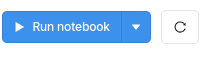

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

## Extra points

You can earn extra 2 points if all your experiments are logged with [Weights and Biases](http://wandb.ai)


# Problems


## Problem 1 [2p]:

Let's see why GPUs are useful in deep learning. Compare matrix multiplication speed for a few matrix shapes when implemented:
1. as loops in Python
2. using np.einsum
3. using numpy on CPU
4. using pytorch on CPU
5. using pytorch on GPU

Finally, consider two square matrices, $A$ and $B$. We have 4 possibilities of multiplying them or their transpositions:
1. $AB$
2. $A^TB$
3. $AB^T$
4. $A^TB^T$

Which option is the fastest? Why?

## Problem 2: Stochastic Gradient Descent (training MNIST digits) [2p]

We provide below starter code that trains a classification model (with softmat + cross entropy loss). Alternatively, implement your own training loop and use it to solve this problem jointly with the next one.

Implement the following additions to the SGD code provided:
  1. **[1p]** momentum
  2. **[0.5p]** learning rate schedule
  3. **[0.5p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use the function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

## Problem 3: Tuning the Network for MNIST [2p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    a good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

## Problem 4: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

## Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transformations during training, make sure they are re-computed in every epoch. Consider applying augmentation either in the training loop or in the `InMemDataLoader`. For the second case, function `InMemDataLoader.__iter__` is a good place to do it.


## Problem 6: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

## Problem 7: Batch Normalization [2p]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

## Problem 8: Norm Constraints [1p]

Implement norm constraints, i.e. instead of weight decay, that tries to set all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

## Problem 9: Hyperparameter tuner [2p]

Implement a hyper-parameter tuner able to optimize the learning rate schedule, number of neurons, and similar hyperparameters. To start, use a random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

## Problem 10: Pruning [1p]

Prune the MNIST network to retain validation accuracy no worse than 0.1 percentage point at maximum sparsity (maximal number of weights removed from the network).

One way to do it is to
1. train the network,
2. set to zero the smallest weights (typically you can zero up to 50% of weights)
3. retrain the network, keeping the zeroed weights zeroed, and repeat

## Problem 11: Other tricks [1p-many]

The neural network literature is full of tricks for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand

## Starter code

The code below trains a SoftMax regression model in PyTorch. It can easily be extended into a full multilayer neural network.

In [ ]:
%matplotlib inline

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [ ]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Data loading

Training speed is important. By default, data is loaded on the CPU, then shipped in batches to the GPU. For this exercise, we will load the full dataset onto the GPU, which speeds up training.

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
        transform=None
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.transform = transform

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            batch = self.dataset[batch_indices]
            if self.transform is not None:
                imgs, labels = batch
                imgs = self.transform(imgs)
                batch = (imgs, labels)
            yield batch

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

```python
# Monkey-patch MNIST to use a more robust MNIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
```

In [ ]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.23MB/s]


  0%|          | 0/50000 [00:00<?, ?it/s]

<ipython-input-4-d37f491a7e10>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs while solving the assignments.

In [ ]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    # Initialize momentum variables
    velocities = [torch.zeros_like(p) for p in model.parameters()]

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            # Learning rate schedule
            eff_alpha = alpha * torch.exp(torch.tensor(-0.1 * epoch))

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            # Implement weight decay (L2 regularization)
                            p.grad += decay * p

                        # Velocity updates
                        v[...] = epsilon * v + (1 - epsilon)* p.grad

                        p -= v * eff_alpha
                        p.grad.zero_()


                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)


----------------------------------------------------------
After epoch 29 | valid err rate:  7.66% | doing  29 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 19)

-------------------------------------------
Test error rate: 8.020%, training took 11s.
-------------------------------------------


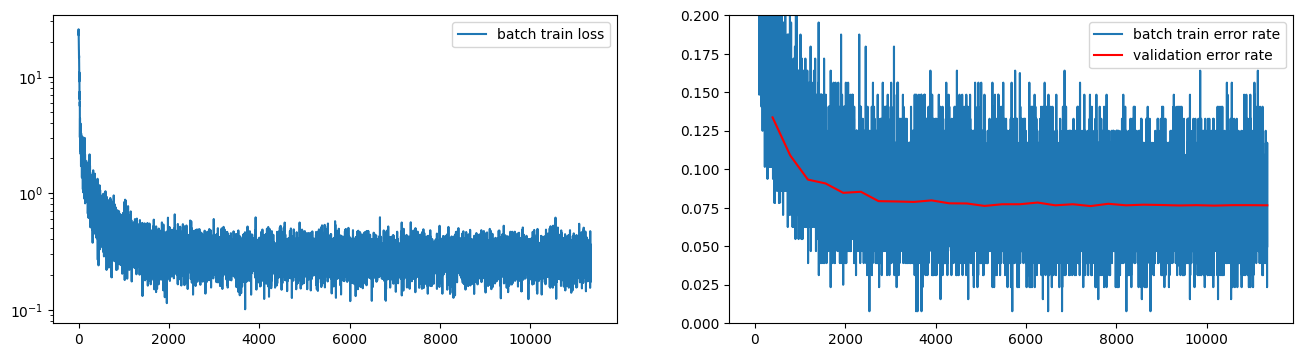

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model2 = Model(nn.Linear(28 * 28, 10))

with torch.no_grad():
    # Initialize parameters
    for name, p in model2.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model2, mnist_loaders, alpha=1e-1, decay=0.01, epsilon=0.9,max_num_epochs=30, device="cuda")


test_err_rate = compute_error_rate(model2, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

## Training function

In [ ]:
import wandb
wandb.login()

In [ ]:
def start_training(model, mnist_loaders, alpha=0.1, decay=0.001, epsilon=0.9, max_num_epochs=30):
    with torch.no_grad():
        for name, p in model.named_parameters():
            if isinstance(p, (nn.BatchNorm1d, nn.BatchNorm2d)):
                p.weight.data.ones_()
                p.bias.data.zero_()
            elif "weight" in name:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif "bias" in name:
                p.zero_()
            else:
                raise ValueError('Unknown parameter name "%s"' % name)

    t_start = time.time()
    SGD(model, mnist_loaders, alpha=alpha, decay=decay, epsilon=epsilon, max_num_epochs=max_num_epochs, device="cuda")

    test_err_rate = compute_error_rate(model, mnist_loaders["test"])
    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))

## Problem 1

In [ ]:
import numpy as np
import torch
import time

In [ ]:
# Define matrix shapes to test
shapes = [(100, 100), (200, 200), (500, 500)]

# Function to measure time
def measure_time(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end - start

# 1. Matrix multiplication as loops in Python
def matmul_loops(A, B):
    result = [[0] * len(B[0]) for _ in range(len(A))]
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                result[i][j] += A[i][k] * B[k][j]
    return result

# 2. Matrix multiplication using np.einsum
def matmul_einsum(A, B):
    return np.einsum('ik,kj->ij', A, B)

# 3. Matrix multiplication using numpy on CPU
def matmul_numpy(A, B):
    return np.dot(A, B)

# 4. Matrix multiplication using pytorch on CPU
def matmul_torch_cpu(A, B):
    A_torch = torch.from_numpy(A)
    B_torch = torch.from_numpy(B)
    return torch.mm(A_torch, B_torch)

# 5. Matrix multiplication using pytorch on GPU
def matmul_torch_gpu(A, B):
    A_torch = torch.from_numpy(A).cuda()
    B_torch = torch.from_numpy(B).cuda()
    return torch.mm(A_torch, B_torch)

# Compare the speed for different implementations
results = {}
for shape in shapes:
    A = np.random.rand(*shape)
    B = np.random.rand(*shape)

    results[shape] = {
        "loops": measure_time(matmul_loops, A.tolist(), B.tolist()),
        "einsum": measure_time(matmul_einsum, A, B),
        "numpy": measure_time(matmul_numpy, A, B),
        "torch_cpu": measure_time(matmul_torch_cpu, A, B),
        "torch_gpu": measure_time(matmul_torch_gpu, A, B) if torch.cuda.is_available() else "N/A"
    }

# Print the results
for shape, times in results.items():
    print(f"Shape: {shape}")
    for method, time_taken in times.items():
        if time_taken == "N/A":
            print(f"  {method}: N/A")
        else:
            print(f"  {method}: {time_taken:} seconds")
    print()

Shape: (100, 100)
  loops: 0.09940671920776367 seconds
  einsum: 0.0003979206085205078 seconds
  numpy: 0.00032591819763183594 seconds
  torch_cpu: 0.01301717758178711 seconds
  torch_gpu: 0.3304781913757324 seconds

Shape: (200, 200)
  loops: 0.9035732746124268 seconds
  einsum: 0.0025408267974853516 seconds
  numpy: 0.0007295608520507812 seconds
  torch_cpu: 0.0007872581481933594 seconds
  torch_gpu: 0.019004106521606445 seconds

Shape: (500, 500)
  loops: 15.323394060134888 seconds
  einsum: 0.0444796085357666 seconds
  numpy: 0.006766557693481445 seconds
  torch_cpu: 0.009562015533447266 seconds
  torch_gpu: 0.0014190673828125 seconds



In [ ]:
# Function to measure time for different matrix multiplications
def measure_time_transpose(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end - start

# Define the four multiplication options
def matmul_AB(A, B):
    return np.dot(A, B)

# Measure the time for each option
times_transpose = {
    "AB": measure_time_transpose(matmul_AB, A, B),
    "ATB": measure_time_transpose(matmul_AB, A.T, B),
    "ABT": measure_time_transpose(matmul_AB, A, B.T),
    "ATBT": measure_time_transpose(matmul_AB, A.T, B.T)
}

# Print the results
for method, time_taken in times_transpose.items():
    print(f"{method}: {time_taken} seconds")

AB: 0.009331703186035156 seconds
ATB: 0.0066492557525634766 seconds
ABT: 0.006150245666503906 seconds
ATBT: 0.006525516510009766 seconds


The fastest option for multiplying two square matrices $A$ and $B$ is $A^TB$.

This is because matrix transposition can lead to better memory access patterns and cache utilization, which can significantly speed up the computation. When matrices are stored in a row-major order (as in C and NumPy), accessing elements in a column-major order (as in the case of $AB$) can lead to inefficient memory access patterns. Transposing one of the matrices (as in $A^TB$) can help align the memory access patterns more efficiently, leading to faster computation times.

## Problem 3

----------------------------------------------------------
After epoch 13 | valid err rate:  1.87% | doing  13 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 8)

-------------------------------------------
Test error rate: 1.920%, training took 51s.
-------------------------------------------


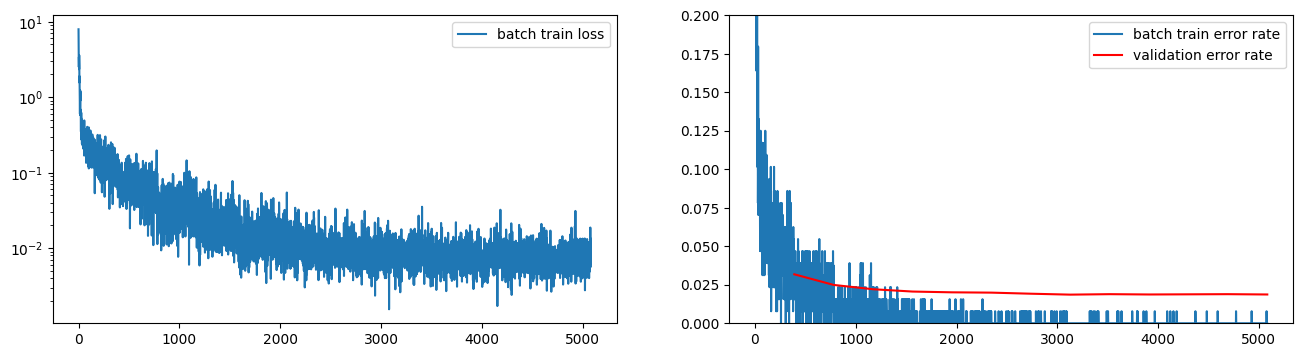

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model3 = Model(
    nn.Linear(28 * 28, 784 * 4),
    nn.ReLU(),
    nn.Linear(784 * 4, 784 * 3),
    nn.ReLU(),
    nn.Linear(784 * 3, 784 * 2),
    nn.ReLU(),
    nn.Linear(784 * 2, 784),
)
start_training(model3, mnist_loaders, alpha=0.1, decay=0.001, epsilon=0.9, max_num_epochs=30)



## Problem 4:

----------------------------------------------------------
After epoch 26 | valid err rate:  1.15% | doing  26 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 17)

-------------------------------------------
Test error rate: 1.180%, training took 33s.
-------------------------------------------


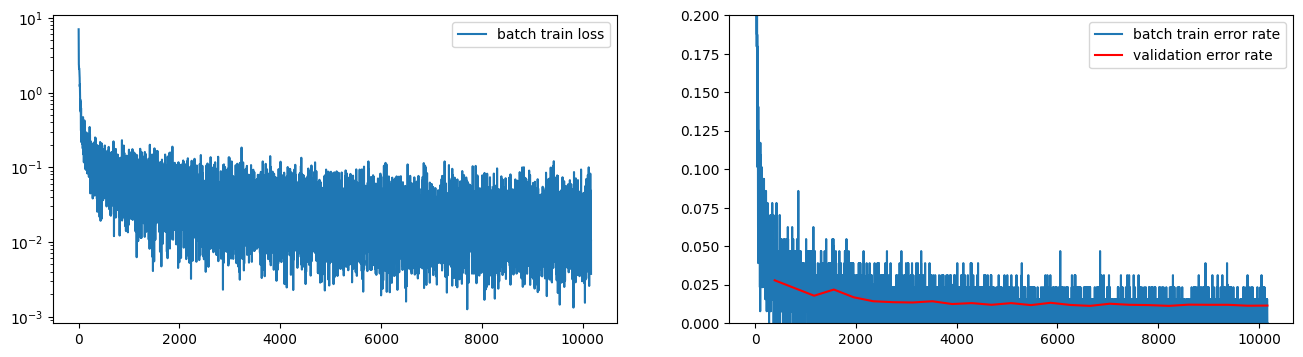

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), 1, 28, 28)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)



model4 = Model(
    nn.Conv2d(1, 10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(10, 20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)


start_training(model4, mnist_loaders, alpha=0.1, decay=0.001, epsilon=0.9, max_num_epochs=30)


## Problem 5:

----------------------------------------------------------
After epoch 30 | valid err rate:  1.32% | doing  46 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 30)

--------------------------------------------
Test error rate: 1.240%, training took 128s.
--------------------------------------------


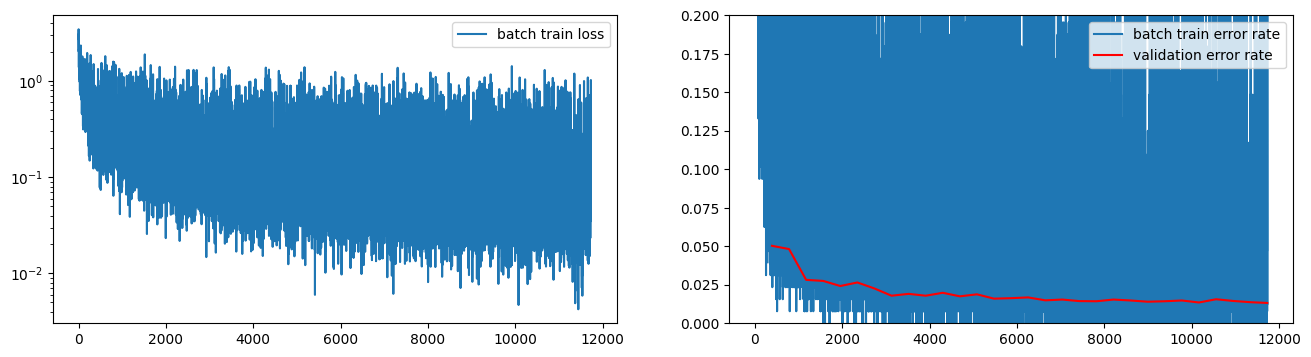

In [ ]:
transform_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    torchvision.transforms.RandomErasing(p=0.2),
])


mnist_loaders_with_aug = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True, transform=transform_augmentation),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model5 = Model(
    nn.Linear(28 * 28, 784 * 4),
    nn.ReLU(),
    nn.Linear(784 * 4, 784 * 3),
    nn.ReLU(),
    nn.Linear(784 * 3, 784 * 2),
    nn.ReLU(),
    nn.Linear(784 * 2, 784),
    nn.ReLU(),
    nn.Linear(784, 10)
)

start_training(model5, mnist_loaders_with_aug, alpha=0.1, decay=0.001, epsilon=0.9, max_num_epochs=30)


## Problem 6:


In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = (torch.rand(x.size()) > self.p).to(x.device)
            x = x * mask / (1 - self.p)
        return x

----------------------------------------------------------
After epoch 37 | valid err rate:  1.03% | doing  37 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 24)

-------------------------------------------
Test error rate: 0.860%, training took 71s.
-------------------------------------------


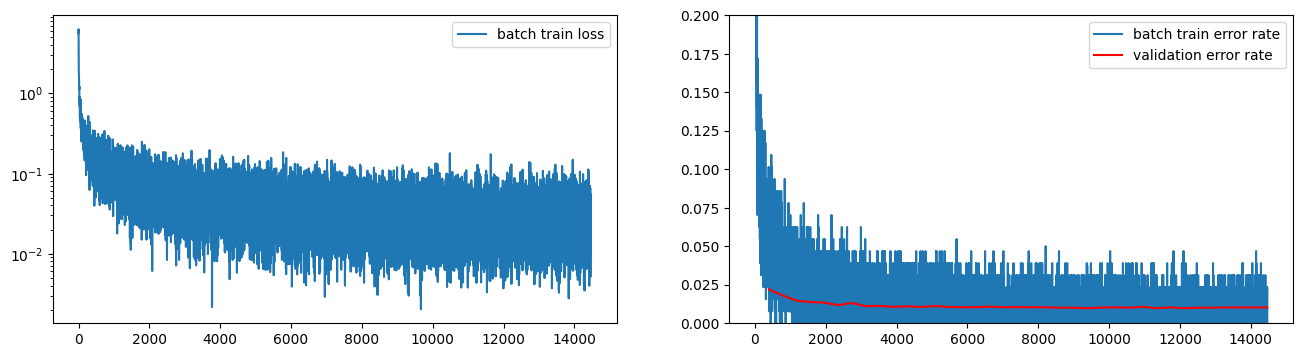

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), 1, 28, 28)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)



model6 = Model(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    MyDropout(p=0.5),
    nn.Linear(128, 10)
)


start_training(model6, mnist_loaders, alpha=0.1, decay=0.001, epsilon=0.9, max_num_epochs=40)


## Problem 7

In [ ]:
# TODO own batch norm
class MyBatchNorm(torch.nn.Module):
    def __init__(self, num_features):
        super(MyBatchNorm, self).__init__()
        self.gamma = torch.nn.Parameter(torch.ones(num_features))
        self.beta = torch.nn.Parameter(torch.zeros(num_features))
        self.eps = 1e-5
        self.momentum = 0.1
        self.moving_mean = torch.zeros(num_features)
        self.moving_var = torch.ones(num_features)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            self.moving_mean = (1 - self.momentum) * self.moving_mean.to(x.device) + self.momentum * mean
            self.moving_var = (1 - self.momentum) * self.moving_var.to(x.device) + self.momentum * var
        else:
            x = (x - self.moving_mean.to(x.device)) / torch.sqrt(self.moving_var.to(x.device) + self.eps)
        return self.gamma.to(x.device) * x + self.beta.to(x.device)
print(repr(MyBatchNorm))

<class '__main__.MyBatchNorm'>


----------------------------------------------------------
After epoch 30 | valid err rate:  0.71% | doing  37 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 24)

-------------------------------------------
Test error rate: 0.800%, training took 62s.
-------------------------------------------


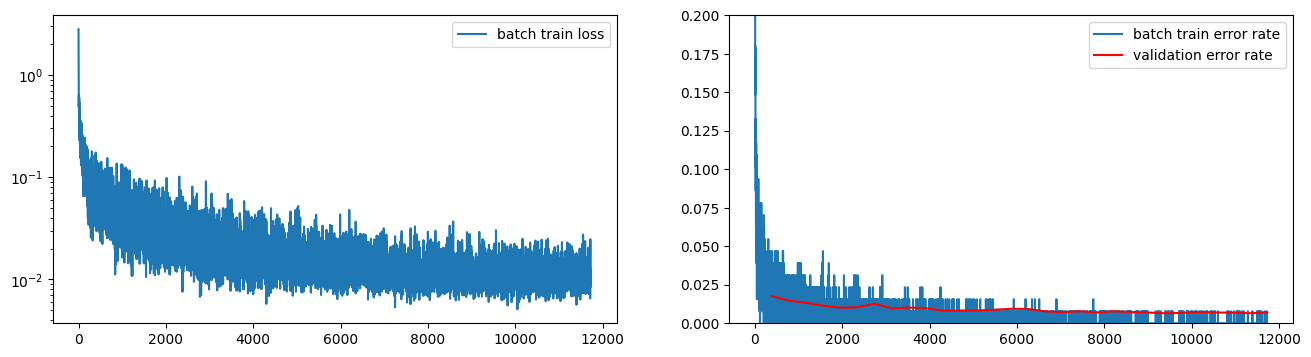

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # Reshape the input to [batch_size, channels, height, width]
        X = X.view(X.size(0), 1, 28, 28)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)



model7 = Model(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    MyBatchNorm(128),
    nn.Linear(128, 10)
)

# start_training(model7, mnist_loaders, alpha=0.1, decay=0.01, epsilon=0.9, max_num_epochs=30)
with torch.no_grad():
  for name, p in model7.named_parameters():
      if "gamma" in name or "beta" in name:
          continue
      elif "weight" in name:
          nn.init.kaiming_normal_(p, nonlinearity='relu')
      elif "bias" in name:
          p.zero_()
      else:
          raise ValueError('Unknown parameter name "%s"' % name)

t_start = time.time()
SGD(model7, mnist_loaders, alpha=0.1, decay=0.01, epsilon=0.9, max_num_epochs=30, device="cuda")

test_err_rate = compute_error_rate(model7, mnist_loaders["test"])
m = (
      f"Test error rate: {test_err_rate * 100.0:.3f}%, "
      f"training took {time.time() - t_start:.0f}s."
  )
print("{0}\n{1}\n{0}".format("-" * len(m), m))


## Problem 8


In [ ]:
def PGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_norm=3.0,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    # Initialize momentum variables
    velocities = [torch.zeros_like(p) for p in model.parameters()]

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            # Learning rate schedule
            eff_alpha = alpha * torch.exp(torch.tensor(-0.1 * epoch))

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if p.grad is None:
                            continue

                        # Velocity updates
                        v[...] = epsilon * v + (1 - epsilon)* p.grad

                        p -= v * eff_alpha
                        p.grad.zero_()

                    # norm constraint
                    for name, param in model.named_parameters():
                        if "weight" in name and param.dim() == 2:
                            row_norms = param.norm(p=2, dim=1, keepdim=True)
                            desired = torch.clamp(row_norms, max=max_norm)
                            param *= (desired / (row_norms + 1e-8))


                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)


----------------------------------------------------------
After epoch 30 | valid err rate:  1.24% | doing  34 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 22)

-------------------------------------------
Test error rate: 1.190%, training took 40s.
-------------------------------------------


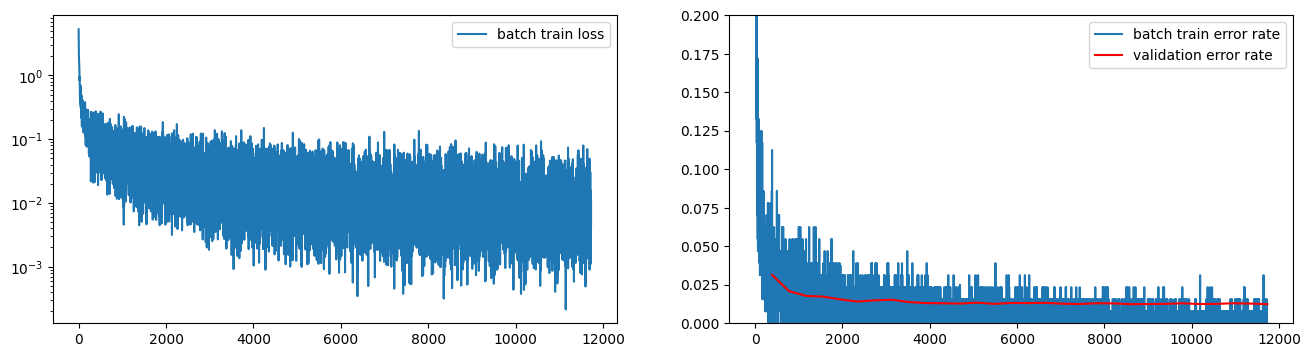

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), 1, 28, 28)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)



model8 = Model(
    nn.Conv2d(1, 10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(10, 20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

with torch.no_grad():
    for name, p in model8.named_parameters():
        if "weight" in name:
            nn.init.kaiming_normal_(p, nonlinearity='relu')
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

t_start = time.time()
PGD(model8, mnist_loaders, alpha=0.1, decay=0.01, epsilon=0.9, max_num_epochs=30, device="cuda")

test_err_rate = compute_error_rate(model8, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


## Problem 9

In [ ]:
import random

def random_hyperparam_sample():
    return {
        "alpha": 10 ** random.uniform(-3, -1),
        "epsilon": random.uniform(0.8, 0.95),
        "hidden1": random.randint(784,784*5),
        "hidden2": random.randint(784,784*5),
        "dropout_p": random.uniform(0.2, 0.5)
    }



def make_model(hidden1, hidden2, dropout_p):
    class TunedModel(nn.Module):
        def __init__(self):
            super().__init__()
            layers = [
                nn.Flatten(),
                nn.Linear(28 * 28, hidden1),
                nn.ReLU(),
                nn.Dropout(p=dropout_p),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(p=dropout_p),
                nn.Linear(hidden2, 10)
            ]
            self.layers = nn.Sequential(*layers)

        def forward(self, x):
            return self.layers(x)

        def loss(self, out, target):
            return F.cross_entropy(out, target)

    model = TunedModel()
    with torch.no_grad():
        for name, p in model.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif "bias" in name:
                p.zero_()
            else:
                raise ValueError('Unknown parameter name "%s"' % name)
    return model

def hyperparam_search(num_trials, max_epochs, device="cpu"):
    best_model = None
    best_params = None
    best_error = float("inf")

    for i in range(num_trials):
        print(f"\n=== Trial {i+1}/{num_trials} ===")
        h = random_hyperparam_sample()
        print("Hyperparameters:", h)

        model = make_model(h["hidden1"], h["hidden2"], h["dropout_p"])

        SGD(
            model,
            mnist_loaders,
            alpha=h["alpha"],
            epsilon=h["epsilon"],
            max_num_epochs=max_epochs,
            log_every=200,
            device=device,
        )

        test_err = compute_error_rate(model, mnist_loaders["valid"], device)
        print(f"Test error: {test_err:.4f}")

        if test_err < best_error:
            best_error = test_err
            best_model = model
            best_params = h

        if best_error <= 0.013:
            print("Early stopping as best error is below threshold.")
            break

    print("\n=== BEST TRIAL ===")
    print("Test error:", best_error * 100, "%")
    print("Best hyperparameters:", best_params)
    return best_model, best_params



----------------------------------------------------------
After epoch 23 | valid err rate:  1.69% | doing  23 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 15)

Test error: 0.0166

=== BEST TRIAL ===
Test error: 1.66 %
Best hyperparameters: {'alpha': 0.08412316532314347, 'epsilon': 0.8044858157016422, 'hidden1': 3865, 'hidden2': 3372, 'dropout_p': 0.2285070809529607}


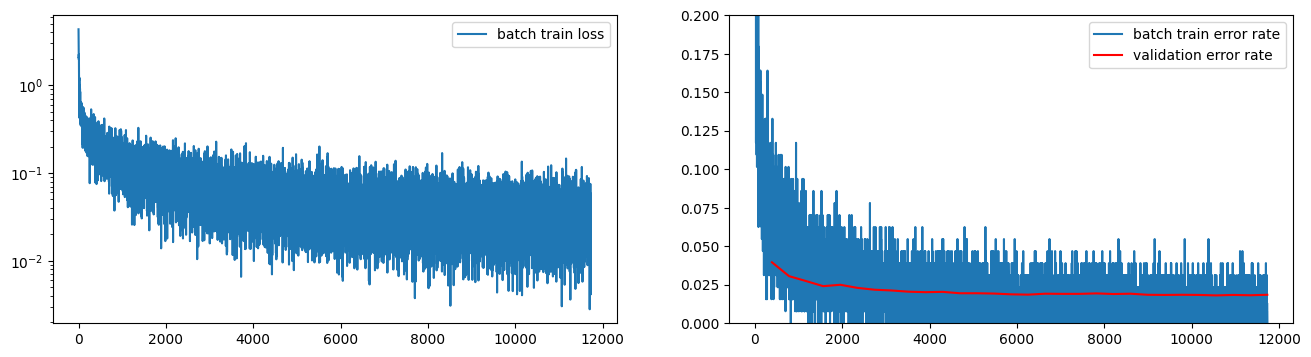

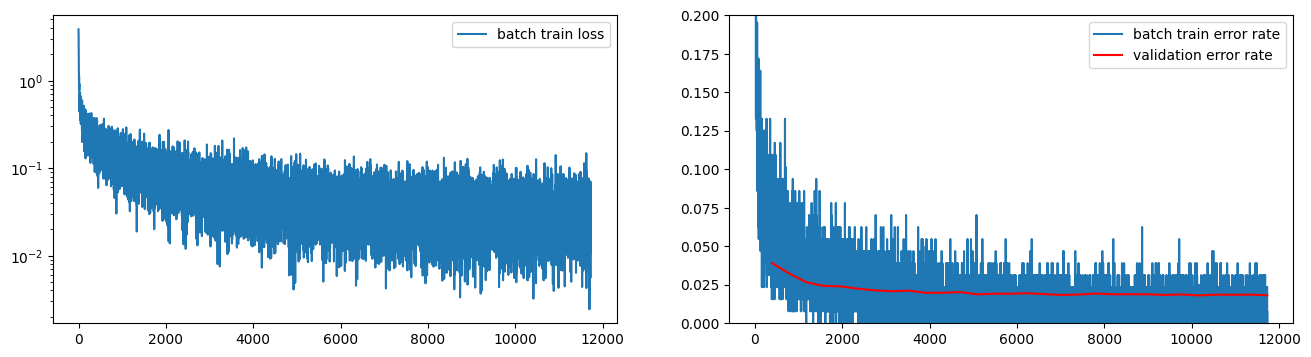

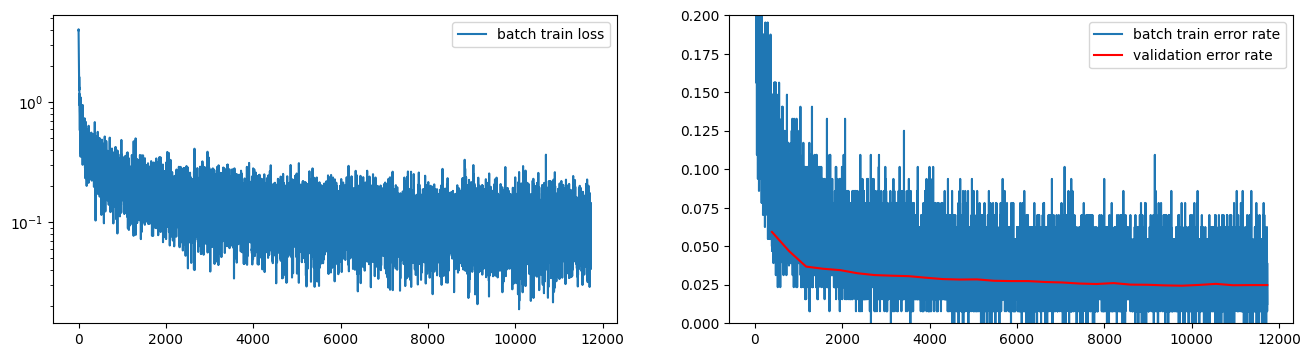

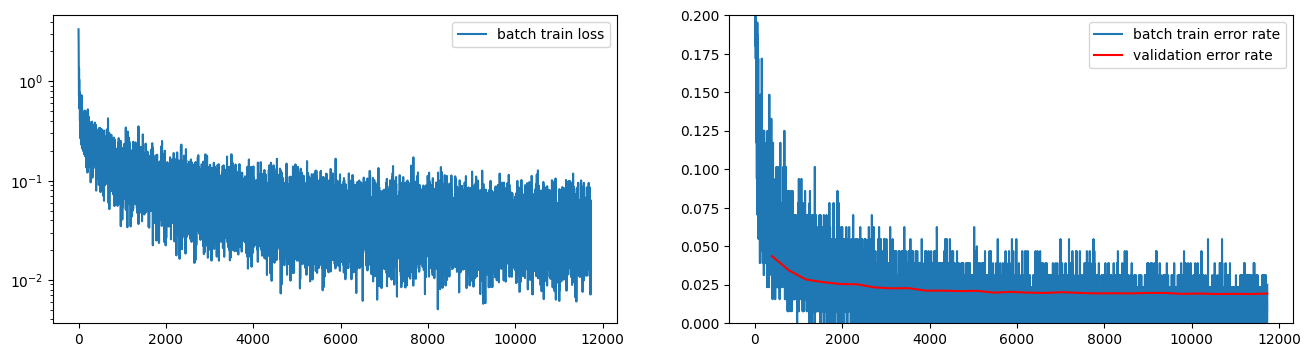

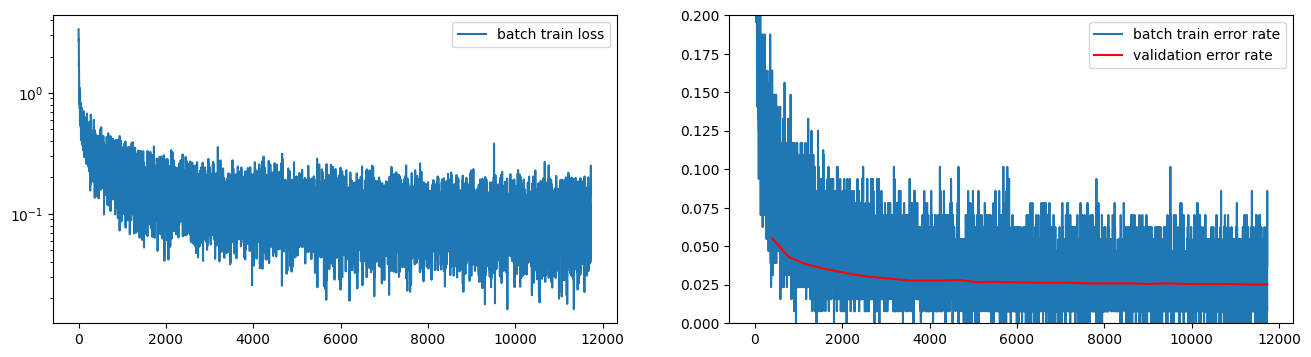

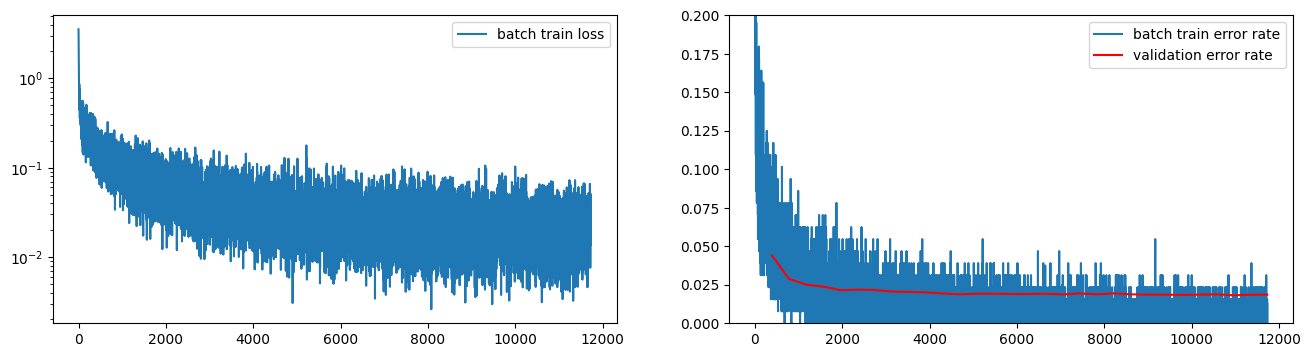

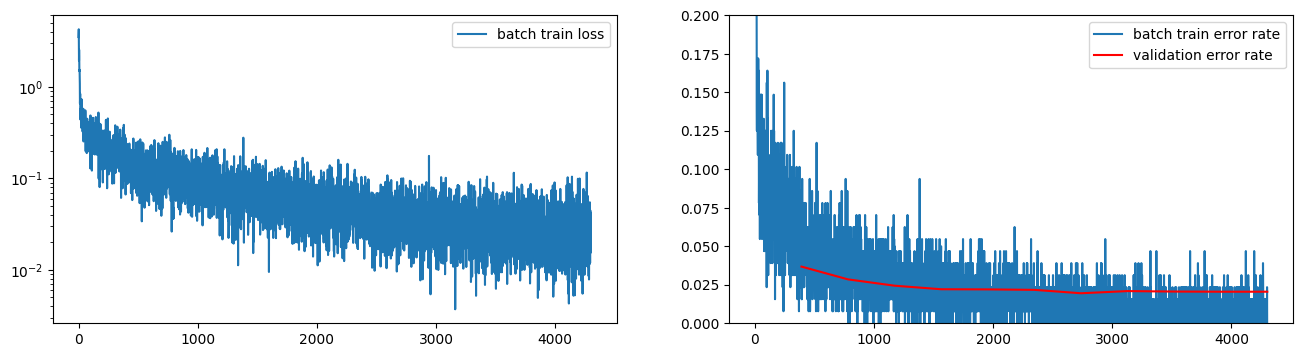

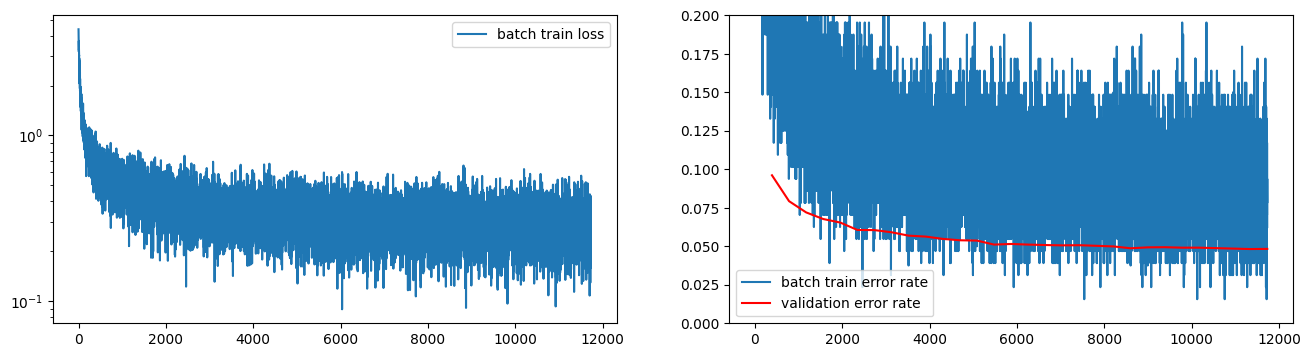

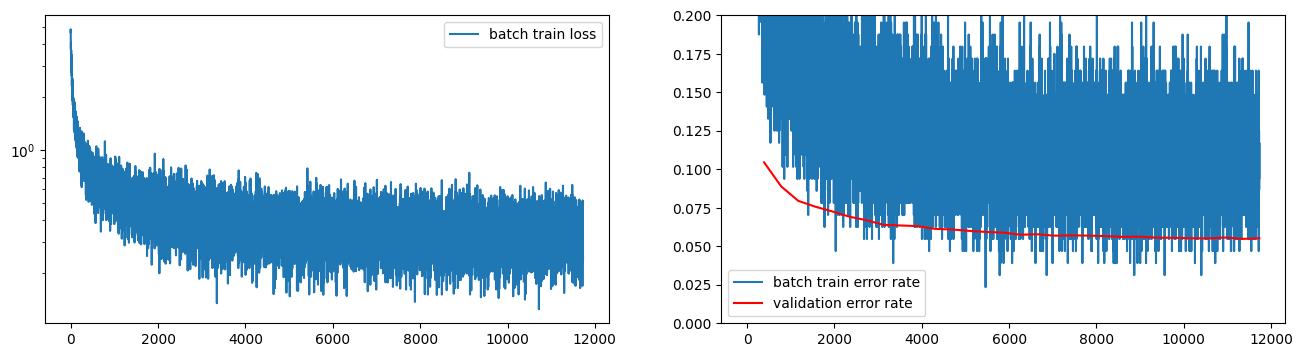

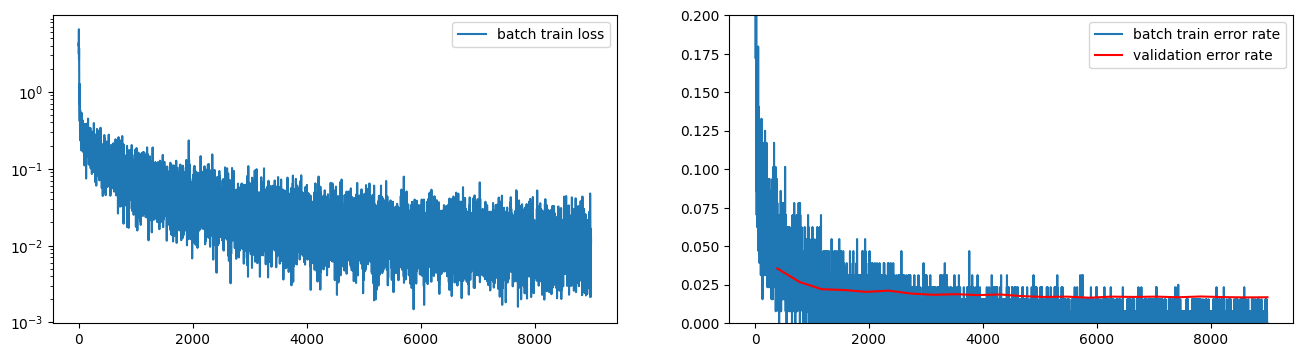

In [ ]:
best_model, best_hparams = hyperparam_search(num_trials=10, max_epochs=30, device="cuda")


## Problem 10

In [ ]:
def prune_weights(model, amount=0.2):
    with torch.no_grad():
        masks = {}
        for name, param in model.named_parameters():
            if "weight" in name and param.dim() == 2:
                flat = param.abs().flatten()
                k = int(amount * flat.numel())
                if k == 0:
                    continue
                threshold = flat.kthvalue(k).values.item()
                mask = (param.abs() >= threshold).float()
                param.mul_(mask)  # Zero out small weights
                masks[name] = mask
    return masks


In [ ]:
def iterative_prune(model, data_loaders, steps=[0.3, 0.5, 0.7, 0.9]):
    for prune_ratio in steps:
        SGD(
            model,
            data_loaders,
            alpha=0.05,
            epsilon=0.9,
            max_num_epochs=10,
            device="cuda")

        masks = prune_weights(model, amount=prune_ratio)
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in masks:
                    param.mul_(masks[name])


        val_err = compute_error_rate(model, data_loaders["valid"])
        print(f"Validation error: {val_err:.4f}")



----------------------------------------------------------
After epoch  5 | valid err rate:  1.02% | doing   5 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 3)

Validation error: 0.0271


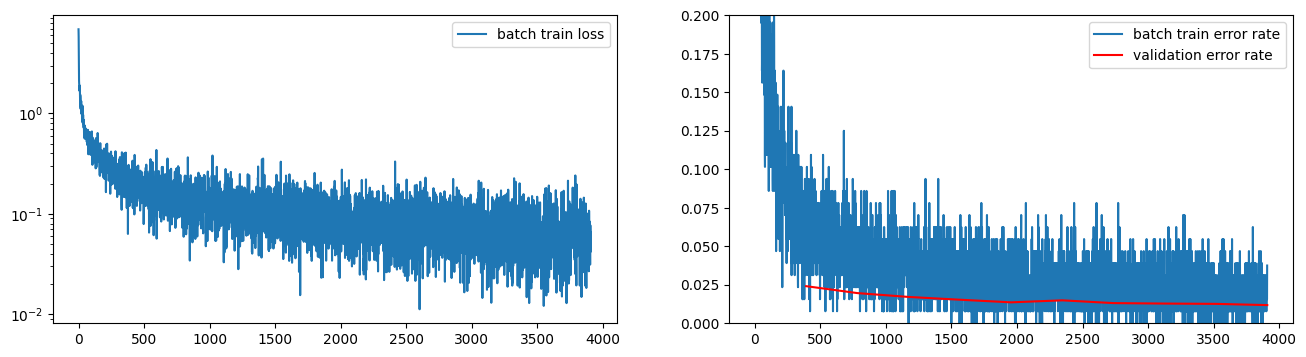

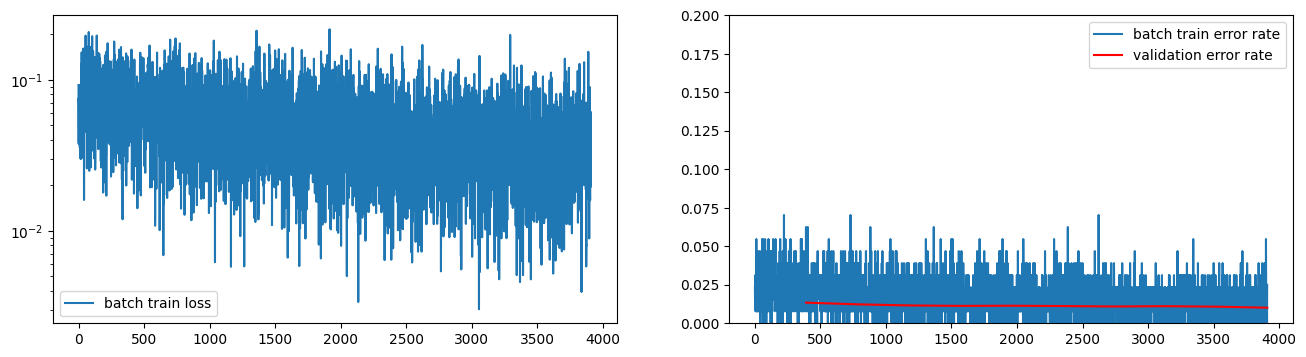

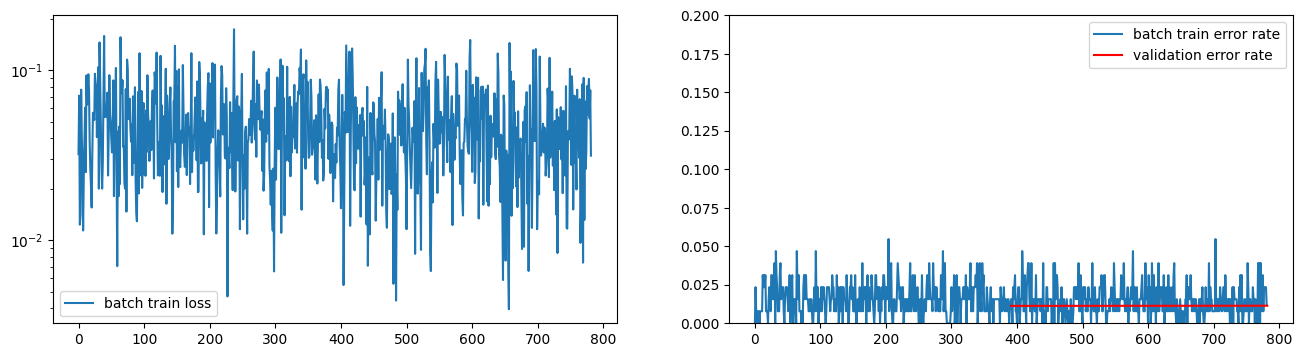

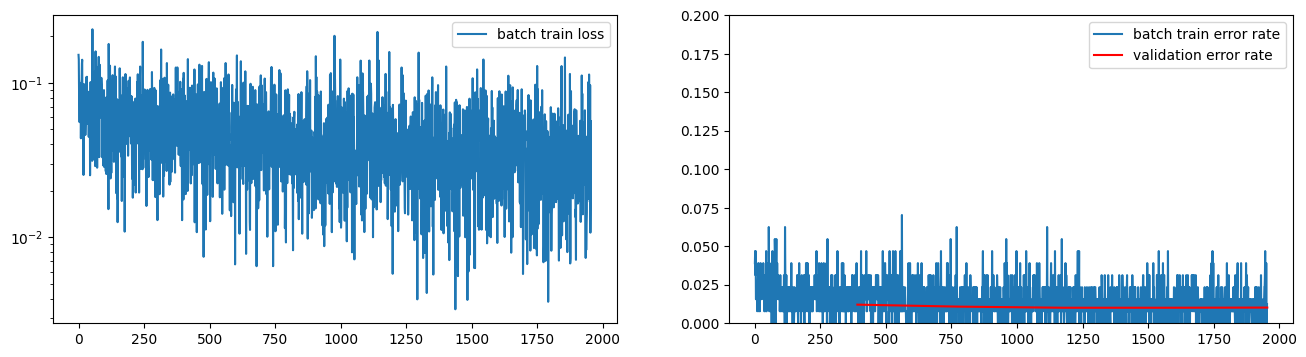

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # Reshape the input to [batch_size, channels, height, width]
        X = X.view(X.size(0), 1, 28, 28)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)



model10 = Model(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 10)
)

with torch.no_grad():
        for name, p in model10.named_parameters():
            if isinstance(p, (nn.BatchNorm1d, nn.BatchNorm2d)):
                p.weight.data.ones_()
                p.bias.data.zero_()
            elif "weight" in name:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif "bias" in name:
                p.zero_()
            else:
                raise ValueError('Unknown parameter name "%s"' % name)

iterative_prune(model10, mnist_loaders, steps=[0.3, 0.5, 0.7, 0.9])
